# Object Detection on a Custom Dataset using YOLO v5

> TL;DR Learn how to build a custom dataset for YOLO v5 (darknet compatible) and use it to fine-tune a large object detection model. The model will be ready for real-time object detection on mobile devices.

In this tutorial, you'll learn how to fine-tune a pre-trained YOLO v5 model for detecting and classifying clothing items from images.

- [Read the tutorial](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1e4zvS6LyhOAayEDh3bz8MXFTJcVFSvZX?usp=sharing)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

Here's what we'll go over:

- Install required libraries
- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions

How good our final model is going to be?



In [ ]:
!nvidia-smi

Tue Jun 23 18:23:12 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!sudo apt-get install tree -qq > /dev/null

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


## Prerequisites

Let's start by installing some required libraries by the YOLOv5 project:

In [ ]:
!pip install torch==1.5.1+cu101 torchvision==0.6.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install numpy==1.17
!pip install PyYAML==5.3.1
!pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 20.4MB 1.4MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5


     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=9430c6a87853981e597558532ef2e0eeffbc25e90862ccca663242abe081ef9d
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built PyYAML
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-6jgreaxq
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-6jgreaxq
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266980 sha256=c842acbdb2c0fed8a74b1f99b9a5075e95f043a3b11baf25046050a85a3de740
  Stored in directory: /tmp/pip-ephem-wheel-cache-5zqok5_d/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing insta

We'll also install [Apex by NVIDIA](https://nvidia.github.io/apex/) to speed up the training of our model (this step is optional):

In [ ]:
!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" . --user && cd .. && rm -rf apex

Cloning into 'apex'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 7274 (delta 9), reused 6 (delta 0), pack-reused 7255
Receiving objects: 100% (7274/7274), 13.86 MiB | 23.08 MiB/s, done.
Resolving deltas: 100% (4910/4910), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-26lwc5u5
Created temporary directory: /tmp/pip-req-tracker-h3_uwgux
Created requirements tracker '/tmp/pip-req-tracker-h3_uwgux'
Created temporary directory: /tmp/pip-install-jl3_fdxl
Processing /content/apex
  Created temporary directory: /tmp/pip-req-build-ynrq9uyn
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-h3_uwgux'
    Running setup.py (

## Build a dataset

The dataset contains annotations for clothing items - bounding boxes around shirts, tops, jackets, sunglasses. The dataset is from [DataTurks](https://dataturks.com/) and is on [Kaggle](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce).

In [ ]:
!gdown --id 1uWdQ2kn25RSQITtBHa9_zayplm27IXNC

Downloading...
From: https://drive.google.com/uc?id=1uWdQ2kn25RSQITtBHa9_zayplm27IXNC
To: /content/clothing.json
100% 199k/199k [00:00<00:00, 62.4MB/s]


The dataset contains a single JSON file with URLs to all images and bounding box data.

Let's import all required libraries:

In [ ]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Each line in the dataset file contains a JSON object. Let's create a list of all annotations:

In [ ]:
clothing = []
with open("clothing.json") as f:
    for line in f:
        clothing.append(json.loads(line))

Here's an example annotation:

In [ ]:
clothing[0]

{'annotation': [{'imageHeight': 312,
   'imageWidth': 147,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.02040816326530612, 'y': 0.2532051282051282},
    {'x': 0.9931972789115646, 'y': 0.8108974358974359}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/4bb8fd9d-8d52-46c7-aa2a-9c18af10aed6___Data_xxl-top-4437-jolliy-original-imaekasxahykhd3t.jpeg',
 'extras': None}

We have the labels, image dimensions, bounding box points (normalized in 0-1 range), and an URL to the image file.

Do we have images with multiple annotations?

In [ ]:
for c in clothing:
  if len(c['annotation']) > 1:
    display(c)

{'annotation': [{'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Jackets'],
   'notes': '',
   'points': [{'x': 0, 'y': 0.6185897435897436},
    {'x': 0.026415094339622643, 'y': 0.6185897435897436}]},
  {'imageHeight': 312,
   'imageWidth': 265,
   'label': ['Skirts'],
   'notes': '',
   'points': [{'x': 0.01509433962264151, 'y': 0.03205128205128205},
    {'x': 1, 'y': 0.9839743589743589}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/b3be330c-c211-45bb-b244-11aef08021c8___Data_free-sk-5108-mudrika-original-imaf4fz626pegq9f.jpeg',
 'extras': None}

Just a single example. We'll need to handle it, though. 

Let's get all unique categories:

In [ ]:
categories = []
for c in clothing:
  for a in c['annotation']:
    categories.extend(a['label'])
categories = list(set(categories))
categories.sort()
categories

['Jackets',
 'Jeans',
 'Shirts',
 'Shoes',
 'Skirts',
 'Tops',
 'Trousers',
 'Tshirts',
 'sunglasses']

We have 9 different categories. Let's split the data into a training and validation set:

In [ ]:
train_clothing, val_clothing = train_test_split(clothing, test_size=0.1)
len(train_clothing), len(val_clothing)

(453, 51)

### Sample image and annotation

Let's have a look at an image from the dataset. We'll start by downloading it:

In [ ]:
row = train_clothing[10]

img = urllib.request.urlopen(row["content"])
img = Image.open(img)
img = img.convert('RGB')

img.save("demo_image.jpeg", "JPEG")

In [ ]:
row

{'annotation': [{'imageHeight': 312,
   'imageWidth': 145,
   'label': ['Tops'],
   'notes': '',
   'points': [{'x': 0.013793103448275862, 'y': 0.22756410256410256},
    {'x': 1, 'y': 0.7948717948717948}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb063ad2b650163b00a1ead0017/ec339ad6-6b73-406a-8971-f7ea35d47577___Data_s-top-203-red-srw-original-imaf2nfrxdzvhh3k.jpeg',
 'extras': None}

We can use OpenCV to read the image:

In [ ]:
img = cv2.cvtColor(cv2.imread(f'demo_image.jpeg'), cv2.COLOR_BGR2RGB)
img.shape

(312, 145, 3)

Let's add the bounding box on top of the image along with the label:

In [ ]:
for a in row['annotation']:
  for label in a['label']:

    w = a['imageWidth']
    h = a['imageHeight']

    points = a['points']
    p1, p2 = points

    x1, y1 = p1['x'] * w, p1['y'] * h
    x2, y2 = p2['x'] * w, p2['y'] * h

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x2), int(y2)),
      color=(0, 255, 0),
      thickness=2
    )

    ((label_width, label_height), _) = cv2.getTextSize(
        label, 
        fontFace=cv2.FONT_HERSHEY_PLAIN,
        fontScale=1.75, 
        thickness=2
    )

    cv2.rectangle(
      img,
      (int(x1), int(y1)),
      (int(x1 + label_width + label_width * 0.05), int(y1 + label_height + label_height * 0.25)),
      color=(0, 255, 0),
      thickness=cv2.FILLED
    )

    cv2.putText(
      img,
      label,
      org=(int(x1), int(y1 + label_height + label_height * 0.25)), # bottom left
      fontFace=cv2.FONT_HERSHEY_PLAIN,
      fontScale=1.75,
      color=(255, 255, 255),
      thickness=2
    )

The point coordinates are converted back to pixels and used to draw rectangles over the image. Here's the result:

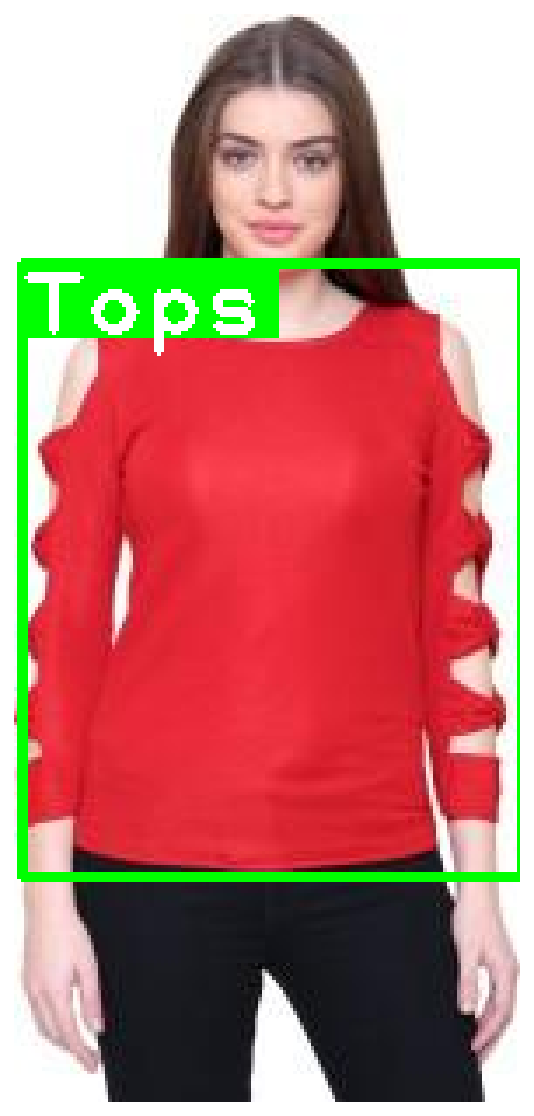

In [ ]:
plt.imshow(img)
plt.axis('off');

### Convert to YOLO format

YOLO v5 requires the dataset to be in the *darknet format*. Here's an outline of what it looks like:

- One txt with labels file per image
- One row per object
- Each row contains: `class_index bbox_x_center bbox_y_center bbox_width bbox_height`
- Box coordinates must be normalized between 0 and 1

Let's create a helper function that builds a dataset in the correct format for us:

In [ ]:
def create_dataset(clothing, categories, dataset_type):

  images_path = Path(f"clothing/images/{dataset_type}")
  images_path.mkdir(parents=True, exist_ok=True)

  labels_path = Path(f"clothing/labels/{dataset_type}")
  labels_path.mkdir(parents=True, exist_ok=True)

  for img_id, row in enumerate(tqdm(clothing)):

    image_name = f"{img_id}.jpeg"

    img = urllib.request.urlopen(row["content"])
    img = Image.open(img)
    img = img.convert("RGB")

    img.save(str(images_path / image_name), "JPEG")

    label_name = f"{img_id}.txt"

    with (labels_path / label_name).open(mode="w") as label_file:

      for a in row['annotation']:

        for label in a['label']:

          category_idx = categories.index(label)

          points = a['points']
          p1, p2 = points

          x1, y1 = p1['x'], p1['y']
          x2, y2 = p2['x'], p2['y']

          bbox_width = x2 - x1
          bbox_height = y2 - y1

          label_file.write(
            f"{category_idx} {x1 + bbox_width / 2} {y1 + bbox_height / 2} {bbox_width} {bbox_height}\n"
          )

In [ ]:
create_dataset(train_clothing, categories, 'train')
create_dataset(val_clothing, categories, 'val')

100%|██████████| 51/51 [00:07<00:00,  6.48it/s]


In [ ]:
!tree clothing -L 2

clothing
├── images
│   ├── train
│   └── val
└── labels
    ├── train
    └── val

6 directories, 0 files


In [ ]:
!cat clothing/labels/train/0.txt

4 0.525462962962963 0.5432692307692308 0.9027777777777778 0.9006410256410257


## Fine-tuning YOLO v5

The YOLO abbreviation stands for You Only Look Once. YOLO models are one stage object detectors. 

YOLO models are very light and fast. They are [not the most accurate object detections around](https://paperswithcode.com/sota/object-detection-on-coco), though. Ultimately, those models are the choice of many (if not all) practitioners interested in [real-time object detection (FPS >30)](https://paperswithcode.com/sota/real-time-object-detection-on-coco).

### Contreversy

Joseph Redmon introduced YOLO v1 in the 2016 paper [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/pdf/1506.02640.pdf). The implementation uses the [Darknet Neural Networks library](https://pjreddie.com/darknet/).

He also co-authored the YOLO v2 paper in 2017  [YOLO9000: Better, Faster, Stronger](https://arxiv.org/pdf/1612.08242.pdf). A significant improvement over the first iteration with much better localization of objects.

The final iteration, from the original author, was published in the 2018 paper [YOLOv3: An Incremental Improvement](https://arxiv.org/pdf/1804.02767.pdf).

Then things got a bit wacky. Alexey Bochkovskiy published [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/abs/2004.10934) on April 23, 2020. The project has [an open-source repository on GitHub](https://github.com/AlexeyAB/darknet).

YOLO v5 got open-sourced on [May 30, 2020](https://github.com/ultralytics/yolov5/commit/1e84a23f38fad9e52b59101e9f1246d93066ed1e) by [Glenn Jocher](https://github.com/glenn-jocher) from ultralytics. There is no published paper, but [the complete project is on GitHub](https://github.com/ultralytics/yolov5).

The community at Hacker News got into a [heated debate about the project naming](https://news.ycombinator.com/item?id=23478151). Even the guys at Roboflow wrote [Responding to the Controversy about YOLOv5](https://blog.roboflow.ai/yolov4-versus-yolov5/) article about it. They also did a great comparison between YOLO v4 and v5.

My opinion? As long as you put out your work for the whole world to use/see - I don't give a flying fuck. I am not going to comment on points/arguments that are obvious.

### YOLO v5 project setup

YOLO v5 uses PyTorch, but everything is abstracted away. You need the project itself (along with the required dependencies).

Let's start by cloning the GitHub repo and checking out a specific commit (to ensure reproducibility):

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git checkout ec72eea62bf5bb86b0272f2e65e413957533507f

Cloning into 'yolov5'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 729 (delta 36), reused 39 (delta 20), pack-reused 666
Receiving objects: 100% (729/729), 3.37 MiB | 18.46 MiB/s, done.
Resolving deltas: 100% (471/471), done.
/content/yolov5
Note: checking out 'ec72eea62bf5bb86b0272f2e65e413957533507f'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at ec72eea Merge remote-tracking branch 'origin/master'


We need two configuration files. One for the dataset and one for the model we're going to use. Let's download them:

In [ ]:
!gdown --id 1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO -O data/clothing.yaml
!gdown --id 1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i -O models/yolov5x.yaml

Downloading...
From: https://drive.google.com/uc?id=1ZycPS5Ft_0vlfgHnLsfvZPhcH6qOAqBO
To: /content/yolov5/data/clothing.yaml
100% 172/172 [00:00<00:00, 293kB/s]
Downloading...
From: https://drive.google.com/uc?id=1czESPsKbOWZF7_PkCcvRfTiUUJfpx12i
To: /content/yolov5/models/yolov5x.yaml
100% 1.58k/1.58k [00:00<00:00, 2.67MB/s]


The model config changes the number of classes to 9 (equal to the ones in our dataset). The dataset config `clothing.yaml` is a bit more complex:

```yaml
train: ../clothing/images/train/
val: ../clothing/images/val/

nc: 9

names: ['Jackets', 'Jeans', 'Shirts', 'Shoes', 'Skirts', 'Tops', 'Trousers', 'Tshirts', 'sunglasses']
```

This file specifies the paths to the training and validation sets. It also gives the number of classes and their names (you should order those correctly).

### Training

Fine-tuning an existing model is very easy. We'll use the largest model **YOLOv5x** (89M parameters), which is also the most accurate.

In our case, we don't really care about speed. We just want the best accuracy you can get. The checkpoint you're going to use for a different problem(s) is contextually specific. [Take a look at the overview of the pre-trained checkpoints](https://github.com/ultralytics/yolov5/blob/f9ae460eeccd30bdc43a89a37f74b9cc7b93d52f/README.md#pretrained-checkpoints).

To train a model on a custom dataset, we'll call the `train.py` script. We'll pass a couple of parameters:

- img 640 - resize the images to 640x640 pixels
- batch 4 - 4 images per batch
- epochs 30 - train for 30 epochs
- data ./data/clothing.yaml - path to dataset config
- cfg ./models/yolov5x.yaml - model config
- weights yolov5x.pt - use pre-trained weights from the YOLOv5x model
- name yolov5x_clothing - name of our model
- cache - cache dataset images for faster training


In [ ]:
!python train.py --img 640 --batch 4 --epochs 30 \
  --data ./data/clothing.yaml --cfg ./models/yolov5x.yaml --weights yolov5x.pt \
  --name yolov5x_clothing --cache

{'lr0': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'giou': 0.05, 'cls': 0.58, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.014, 'hsv_s': 0.68, 'hsv_v': 0.36, 'degrees': 0.0, 'translate': 0.0, 'scale': 0.5, 'shear': 0.0}
Namespace(adam=False, batch_size=4, bucket='', cache_images=True, cfg='./models/yolov5x.yaml', data='./data/clothing.yaml', device='', epochs=30, evolve=False, img_size=[640], multi_scale=False, name='yolov5x_clothing', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, weights='yolov5x.pt')
Using CUDA Apex device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

2020-06-23 18:55:09.552820: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/

              from  n    params  module                 

The training took around 30 minutes on Tesla P100. The best model checkpoint is saved to `weights/best_yolov5x_clothing.pt`.

## Evaluation

The project includes a great utility function `plot_results()` that allows you to evaluate your model performance on the last training run:

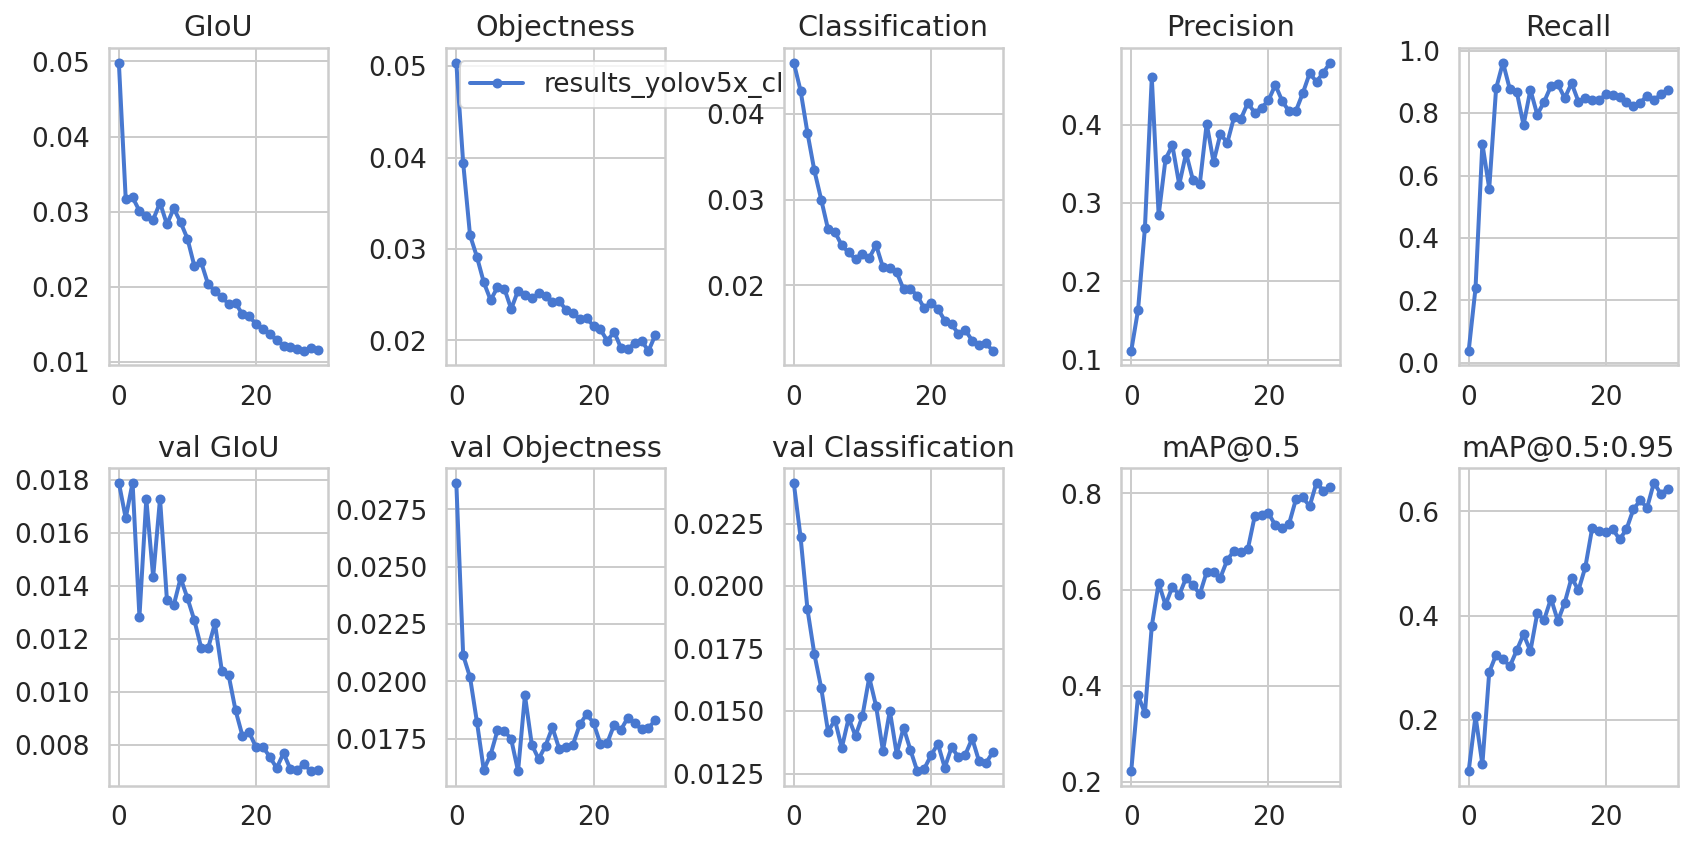

In [ ]:
from utils.utils import plot_results

plot_results();

Looks like the mean average precision (mAP) is getting better throughout the training. The model might benefit from more training, but it is good enough.

## Making predictions

Let's pick 50 images from the validation set and move them to `inference/images` to see how our model does on those:

In [ ]:
!find ../clothing/images/val/ -maxdepth 1 -type f | head -50 | xargs cp -t "./inference/images/"

We'll use the `detect.py` script to run our model on the images. Here are the parameters we're using:

- weights weights/best_yolov5x_clothing.pt - checkpoint of the model
- img 640 - resize the images to 640x640 px
- conf 0.4 - take into account predictions with confidence of 0.4 or higher
- source ./inference/images/ - path to the images

In [ ]:
!python detect.py --weights weights/best_yolov5x_clothing.pt \
  --img 640 --conf 0.4 --source ./inference/images/

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', fourcc='mp4v', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='./inference/images/', view_img=False, weights='weights/best_yolov5x_clothing.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

image 1/52 inference/images/0.jpeg: 320x640 1 sunglassess, Done. (0.032s)
image 2/52 inference/images/1.jpeg: 640x320 1 Skirtss, 1 Topss, Done. (0.032s)
image 3/52 inference/images/10.jpeg: 640x448 1 Tshirtss, Done. (0.034s)
image 4/52 inference/images/11.jpeg: 640x384 1 Shirtss, Done. (0.033s)
image 5/52 inference/images/12.jpeg: 640x256 1 Skirtss, Done. (0.028s)
image 6/52 inference/images/13.jpeg: 640x384 1 Jacketss, Done. (0.033s)
image 7/52 inference/images/14.jpeg: 640x512 1 Shoess, Done. (0.036s)
image 8/52 inference/images/15.jpeg: 640x512 1 Shirtss, 1 Tshirtss, Done. (0.035s)
image 9/52 inference/images/16.jpeg: 640x320 1 Tshir

We'll write a helper function to show the results:

In [ ]:
def load_image(img_path: Path, resize=True):
  img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 256), interpolation = cv2.INTER_AREA)
  return img

def show_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

Here are some of the images along with the detected clothing:

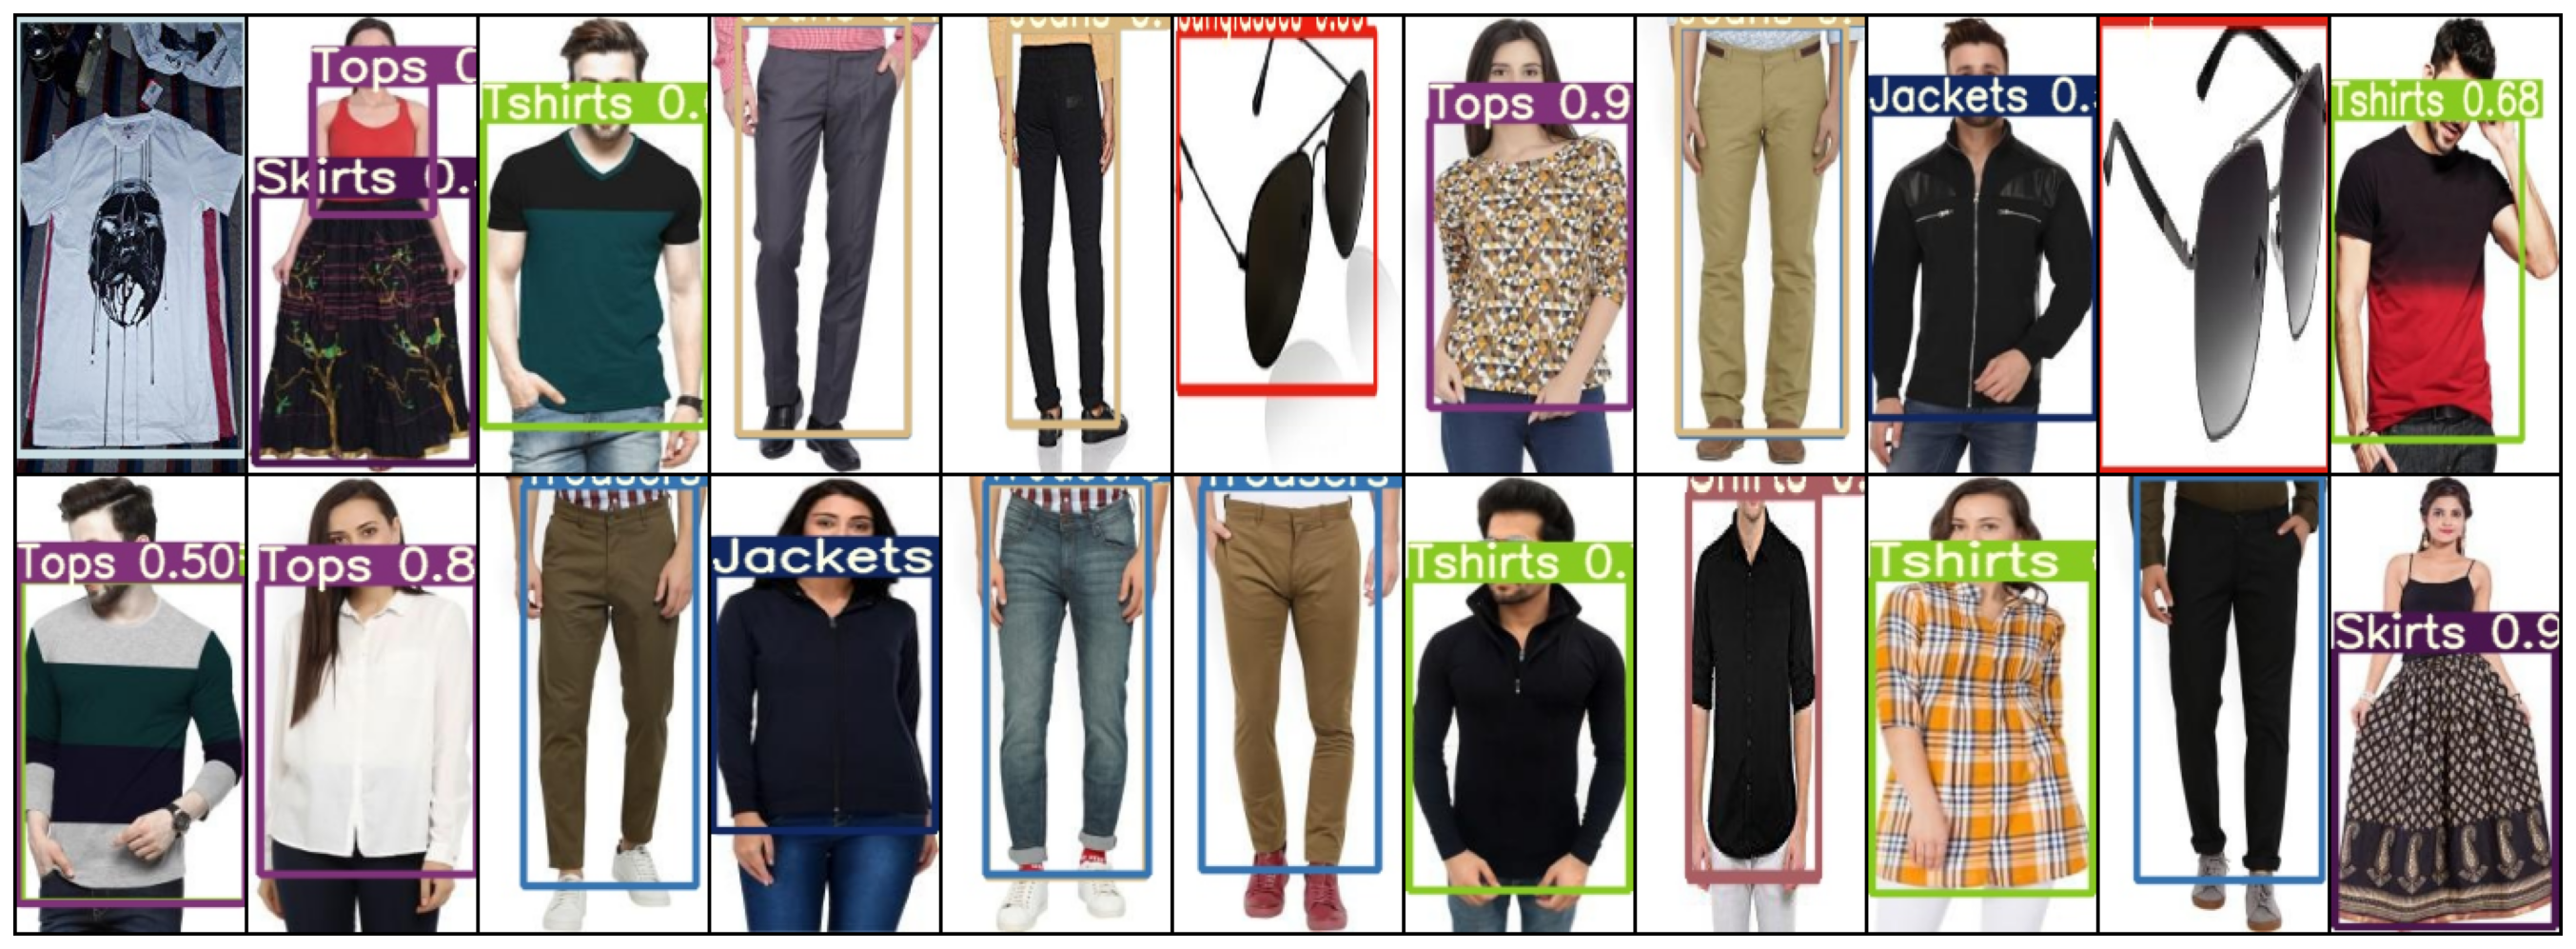

In [ ]:
img_paths = list(Path("inference/output").glob("*.jpeg"))[:22]
show_grid(img_paths)

To be honest with you. I am really blown away with the results!

## Summary

You now know how to create a custom dataset and fine-tune one of the YOLO v5 models on your own. Nice!

- [Read the tutorial](https://www.curiousily.com/posts/object-detection-on-custom-dataset-with-yolo-v5-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1e4zvS6LyhOAayEDh3bz8MXFTJcVFSvZX?usp=sharing)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

Here's what you've learned:

- Install required libraries
- Build a custom dataset in YOLO/darknet format
- Learn about YOLO model family history
- Fine-tune the largest YOLO v5 model
- Evaluate the model
- Look at some predictions

How well does your model do on your dataset? Let me know in the comments below.

In the next part, you'll learn how to deploy your model a mobile device.

## References

- [Clothing Item Detection for E-Commerce dataset](https://www.kaggle.com/dataturks/clothing-item-detection-for-ecommerce)
- [YOLOv5 GitHub](https://github.com/ultralytics/yolov5)
- [YOLOv5 Train on Custom Data](https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data)
- [NVIDIA Apex on GitHub](https://github.com/NVIDIA/apex)
- [YOLOv4: Optimal Speed and Accuracy of Object Detection](https://arxiv.org/pdf/2004.10934.pdf)